Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

our task is to beat it (50.76% accuracy, 101 classes)

In [3]:
#!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-04-06 13:04:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: 'helper_functions.py'

     0K ..........                                            100% 5.04M=0.002s

2025-04-06 13:04:58 (5.04 MB/s) - 'helper_functions.py' saved [10246/10246]



In [4]:
import keras.src.applications.efficientnet

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [ ]:
### 101 food classes: working with less data
# download

In [5]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2025-04-06 13:09:37--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.59, 172.217.17.91, 172.217.19.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: '101_food_classes_10_percent.zip'

     0K .......... .......... .......... .......... ..........  0%  147K 2h59m
    50K .......... .......... .......... .......... ..........  0%  201K 2h35m
   100K .......... .......... .......... .......... ..........  0%  414K 2h5m
   150K .......... .......... .......... .......... ..........  0%  508K 1h46m
   200K .......... .......... .......... .......... ..........  0%  669K 93m22s
   250K .......... .......... .......... .......... ..........  0% 1.02M 82m1s
   300K .......... .......... .......... .......... ..........  0% 1.

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent\test'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\apple_pie'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\baklava'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beef_tartare'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beet_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\beignets'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent\test\bread_pudding'.
There are 0 directories and 250 images in '10

In [7]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir, 
                                                                                label_mode="categorical", 
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode="categorical", 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=False) # don't shuffle prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Train a big dog model with transfer learning on 10% of 101 food classes

# plan
# create ModelCheckpoint callback
# create a data augmentation layer to build data augmentation right into the model
# Build a headless (no top layers) functional EfficientNetB0 backboned-model (our own output layer)
# Compile
# Feature extract for 5 full passes (5 epochs on train dataset and validate on 15% of the test data, to save epoch time)

In [9]:
checkpoint_path = "model_checkpoints/101_food_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor='val_accuracy',
                                                          save_best_only=True)



In [14]:
# data augmentation layer

from keras.src.layers import RandomFlip, RandomRotation, RandomZoom
from keras import Sequential

data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    # RandomHeight(0.2),
    # RandomWidth(0.2),
    RandomZoom(0.2),
    # preprocessing.Rescaling(1./255), # rescale inputs, required for models like ResNet50
], name="data_augmentation")

In [16]:
import keras

# Setup the base model and freeze its layers (extract features)
base_model = keras.src.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = keras.layers.Input(shape=(224,224,3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # put base model in inference mode so weights that need to stay frozen stay frozen
x = keras.layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = keras.layers.Dense(len(train_data_all_10_percent.class_names),
                             activation="softmax",
                             name="output_layer")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pool_layer           │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │       129,381 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [21]:
model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.Adam(),
              metrics=["accuracy"])

history_all_Classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 254s 1s/step - accuracy: 0.1549 - loss: 3.9549 - val_accuracy: 0.4423 - val_loss: 2.5232
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 233s 984ms/step - accuracy: 0.4827 - loss: 2.3324 - val_accuracy: 0.5053 - val_loss: 2.0531
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 231s 977ms/step - accuracy: 0.5440 - loss: 1.9057 - val_accuracy: 0.5283 - val_loss: 1.9220
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.5955 - loss: 1.6711 - val_accuracy: 0.5389 - val_loss: 1.8092
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.6266 - loss: 1.5215 - val_accuracy: 0.5384 - val_loss: 1.7998


In [22]:
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 671s 849ms/step - accuracy: 0.5626 - loss: 1.6802


[1.5649265050888062, 0.5894257426261902]

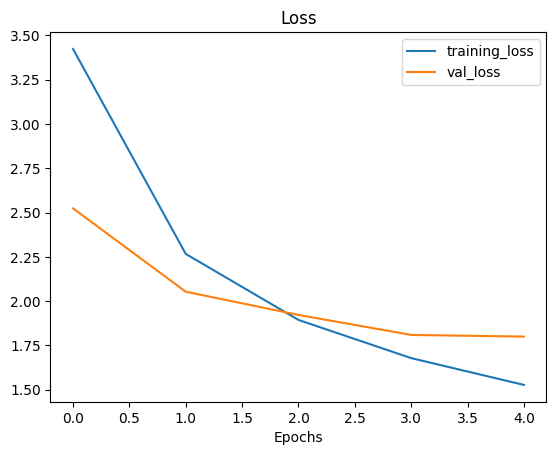

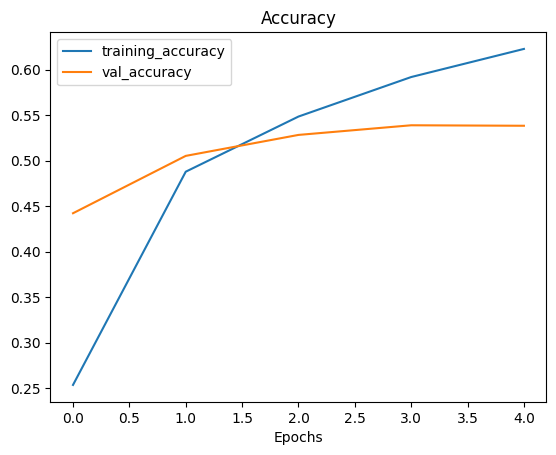

In [23]:
plot_loss_curves(history_all_Classes_10_percent)

In [24]:
#unfreeze all layers in base model

base_model.trainable = True

# Refreeze every layer except last 5
for layer in base_model.layers[:-5]:
    layer.trainable = False


In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [25]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [26]:
for layer_number, layer in enumerate(model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [27]:
FINETUNE_EPOCHS = 10 # 5+5

#finetune our model

history_all_Classes_10_percent_finetune = model.fit(train_data_all_10_percent,
                                                    epochs=FINETUNE_EPOCHS,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_all_Classes_10_percent.epoch[-1],)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.6539 - loss: 1.3913 - val_accuracy: 0.5591 - val_loss: 1.7036
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 226s 957ms/step - accuracy: 0.6732 - loss: 1.2976 - val_accuracy: 0.5620 - val_loss: 1.6916
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 228s 963ms/step - accuracy: 0.6843 - loss: 1.2341 - val_accuracy: 0.5614 - val_loss: 1.6820
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.7098 - loss: 1.1442 - val_accuracy: 0.5588 - val_loss: 1.6951
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.7366 - loss: 1.0659 - val_accuracy: 0.5675 - val_loss: 1.6896
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 271s 1s/step - accuracy: 0.7433 - loss: 1.0384 - val_accuracy: 0.5678 - val_loss: 1.6692


In [28]:
history_all_Classes_10_percent_finetune_results = model.evaluate(test_data)
history_all_Classes_10_percent_finetune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 556s 704ms/step - accuracy: 0.5851 - loss: 1.5805


[1.4681224822998047, 0.606415867805481]

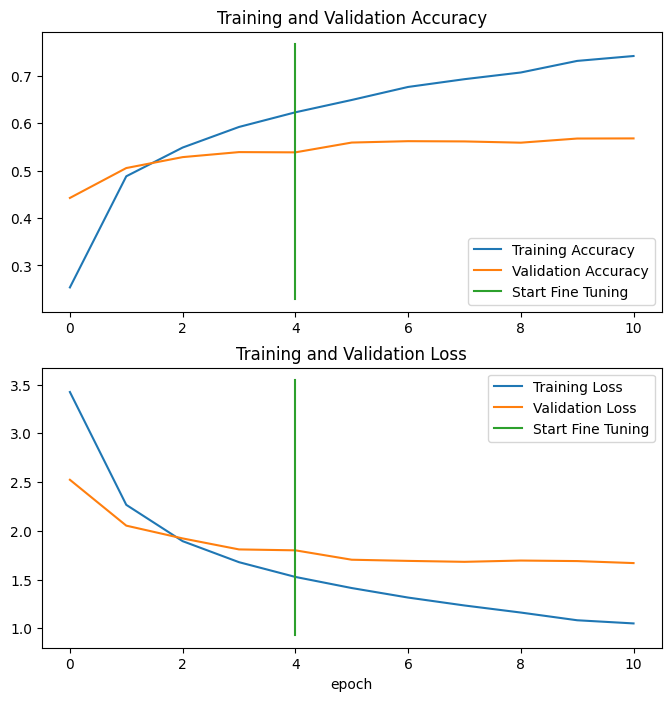

In [29]:
compare_historys(original_history=history_all_Classes_10_percent,
                 new_history=history_all_Classes_10_percent_finetune,
                 initial_epochs=5)

In [31]:
model.save("models/101_food_classes_10_percent.keras")

In [32]:
loaded_model = keras.models.load_model("models/101_food_classes_10_percent.keras")  

C:\code\tesnorflow-udemy\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results


790/790 ━━━━━━━━━━━━━━━━━━━━ 455s 571ms/step - accuracy: 0.5851 - loss: 1.5805


[1.4681224822998047, 0.606415867805481]

In [34]:
history_all_Classes_10_percent_finetune_results

[1.4681224822998047, 0.606415867805481]